## Used to create plots perform analysis of output produced by model.
- Output data will be saved as files and then imported here to analyse/plot.

In [4]:
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

mystyle = r'https://gist.githubusercontent.com/mbolt01/3087dffd11e70eccb08fdcf327374a5c/raw/std_fig'
plt.style.use(mystyle)

## can do my modelling in this notebook too.
import TCP_NTCP as model

## define colours to use for each type
color_p = 'C0'
color_hn = 'C1'

In [2]:
## functions to simply save and load files for use aftger producing modelling results

def save_pkl(obj,filename):
    pickle.dump(obj,open(filename,'wb'))

def load_pkl(filename):
    return pickle.load(open(filename,'rb'))

## example save:
#save_pkl(prost_10year,'test3.pkl')
## example load:
#newtest = load_pkl('test3.pkl')

In [3]:
## for reloading a module.
import importlib
importlib.reload(model)

<module 'TCP_NTCP' from 'C:\\Users\\mb22\\OneDrive\\PhD\\Quasar Shared\\Modelling\\IPython\\Thesis_model_characterisation+simulations\\TCP_NTCP.py'>

## Plot of variation of TCP calc with 'n' and number of repeat optimisations

In [4]:
## load data
repeat_1 = np.load(r'n_val_results.pkl')
repeat_5 = np.load(r'n_val_results-5repeats.pkl')

In [5]:
print(np.std(repeat_1[5]['tcp']))
print(repeat_1[5]['sd']*100)
print(np.mean(repeat_1[5]['tcp']))
print(repeat_1[5]['mean']*100) ## check that sds and means match those from the raw data. All Match OK.

7.42806633053
7.42806633053
83.7537373326
83.7537373326


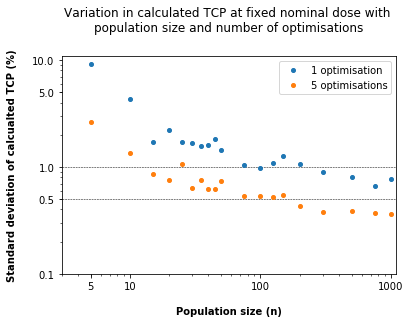

In [6]:
## get mean TCP for each set of data - used to scale the SD to % of TCP
all_1_mean = np.mean([repeat_1[i]['mean'] for i in repeat_1.keys()])
all_5_mean = np.mean([repeat_5[i]['mean'] for i in repeat_5.keys()])

## get SD as a percentage of the mean TCP
all_1_sd = [repeat_1[i]['sd'] for i in sorted(repeat_1.keys())]
all_5_sd = [repeat_5[i]['sd'] for i in sorted(repeat_5.keys())]

## convert sds to percentage of mean TCP
all_1_sd_perc = [100*i/all_1_mean for i in all_1_sd]
all_5_sd_perc = [100*i/all_5_mean for i in all_5_sd]

n_vals = [i for i in sorted(repeat_1.keys())]

## plot the data

plt.loglog(n_vals,all_1_sd_perc,'o', c='C0',ms=4,label='1 optimisation ')
plt.plot(n_vals,all_5_sd_perc,'o',c='C1',ms=4, label='5 optimisations')
plt.ylabel('Standard deviation of calcualted TCP (%)')
plt.xlabel('Population size (n)')
plt.title('Variation in calculated TCP at fixed nominal dose with \npopulation size and number of optimisations')
plt.legend()

#plt.ylim(0.1,10)
plt.yticks([0.1,0.5,1,5,10],['0.1','0.5','1.0','5.0','10.0'])
plt.xlim(3,1100)
plt.xticks([5,10,100,1000],['5','10','100','1000'])
plt.axhline(1,ls='--',c='black',zorder=0,lw=0.5)
plt.axhline(0.5,ls='--',c='black',zorder=0,lw=0.5)

#plt.savefig('N0_determination_n_repeats_variaiton.png',dpi=300,bbox_inches='tight')

plt.show()

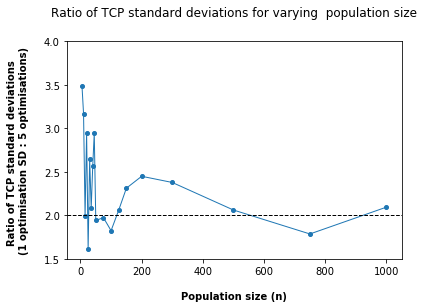

In [7]:
ratios = []
for i in range(len(n_vals)):
    ratios.append(all_1_sd_perc[i]/all_5_sd_perc[i])
plt.plot(n_vals,ratios,ls='-',marker='o',ms='4',lw=1)
plt.axhline(2,c='black',ls='--',lw=1)
plt.ylim(1.5,4)
plt.ylabel('Ratio of TCP standard deviations \n(1 optimisation SD : 5 optimisations)')
plt.xlabel('Population size (n)')
plt.title('Ratio of TCP standard deviations for varying  population size')
plt.show()

## this shows that SD is approximately halved when using 5 repeat optimisaitons for a given n.
## i.e. ~5x more simulations to halve SD

In [8]:
n_vals

[5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 75,
 100,
 125,
 150,
 200,
 300,
 500,
 750,
 1000]

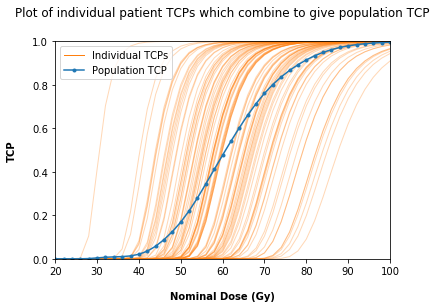

In [9]:
## Produce diagram showing individual patients and population for TCP.
pop_n = 100
TCP_results1 = model.completeTCPcalc(n=pop_n,                  # number of patients in population to model
                                       alphabeta_use=10,       # mean alpha/beta
                                       alphabeta_sd_use=20,    # SD of alpha/beta (%)
                                       d=2,                    # nominal dose (Gy/fraction)
                                       d_shift=0,              # initial dose difference (%)
                                       d_sd=0,                 # standard deviation of delivered dose (%)
                                       d_trend=0,              # dose drift (%/day)
                                       max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                                       dose_of_interest=70,    # dose at which to return seperately the TCPs (Gy)
                                       n0 = 1000000,)          # N0 value supplied (if not supplied, then can be fitted)

## plot individual curves
for i in range(pop_n):
    plt.plot(TCP_results1['nom_doses'],TCP_results1['TCPs'][i],c='C1',
             alpha=0.3,lw=1, label = None)
    
## add fake line for legend with alpha = 1
plt.plot([-1,-1],[-1,-1],c='C1',
         alpha=1,lw=1, label = 'Individual TCPs')

## plot population curves
plt.plot(TCP_results1['nom_doses'],TCP_results1['TCP_pop'],ls='-',c='C0',
         label = 'Population TCP', marker='o',ms=3)
plt.xlim(20,100)
plt.ylim(0,1)
plt.legend()

plt.xlabel('Nominal Dose (Gy)')
plt.ylabel('TCP')
plt.title('Plot of individual patient TCPs which combine to give population TCP')

#plt.savefig('pop_tcp_construction.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
## example TCP modelling (approx H&N?)

model.completeTCPcalc(n=100,                  # number of patients in population to model
                      alphabeta_use=10,       # mean alpha/beta
                      alphabeta_sd_use=20,    # SD of alpha/beta (%)
                      d=2,                    # nominal dose (Gy/fraction)
                      d_shift=0,              # initial dose difference (%)
                      d_sd=3,                 # standard deviation of delivered dose (%)
                      d_trend=0,              # dose drift (%/day)
                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                      dose_input=[35,59],     # known doses corresponding to known TCPs to fit to
                      TCP_input=[0.29,0.83],) # known TCPs corresponding to doses to fit to.

N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 190.049079819

Fitting Completed


{'TCP_cure_percent': 99.993798417357581,
 'TCP_input': [0.29, 0.83],
 'TCP_pop': array([  2.738e-39,   8.111e-19,   1.784e-09,   1.017e-05,   6.174e-04,
          6.206e-03,   2.594e-02,   7.122e-02,   1.521e-01,   2.654e-01,
          3.938e-01,   5.203e-01,   6.336e-01,   7.280e-01,   8.022e-01,
          8.592e-01,   9.007e-01,   9.308e-01,   9.520e-01,   9.669e-01,
          9.772e-01,   9.844e-01,   9.893e-01,   9.926e-01,   9.949e-01,
          9.965e-01,   9.976e-01,   9.983e-01,   9.988e-01,   9.992e-01,
          9.994e-01,   9.996e-01,   9.997e-01,   9.998e-01,   9.999e-01,
          9.999e-01,   9.999e-01,   1.000e+00,   1.000e+00,   1.000e+00,
          1.000e+00,   1.000e+00,   1.000e+00,   1.000e+00,   1.000e+00,
          1.000e+00,   1.000e+00,   1.000e+00,   1.000e+00,   1.000e+00]),
 'TCPs': array([[  2.737e-37,   8.104e-17,   1.771e-07, ...,   1.000e+00,
           1.000e+00,   1.000e+00],
        [  2.383e-54,   1.188e-34,   1.938e-22, ...,   1.000e+00,
           1

## Sensitivity of TCP parameters

## Prostate
### Standard values for population to find N0
- a/b = 1.5
     - Fowler J, Chappell R, Ritter M. Is α/β for prostate tumors really low? Int J Radiat Oncol. 2001 Jul;50(4):1021–31. 
     - Dale textbook
     - Wedenberg M. FROM CELL SURVIVAL TO DOSE RESPONSE – MODELING BIOLOGICAL EFFECTS IN RADIATION THERAPY. Karolinska Institutet; 2013. 
     
- a/b SD = 50% [Dale textbook] = chosen to fit the plots best. Ideally this would be fitted with N0, but not currently possible.
- N0 = to be fitted from population data
- n = 1000
- d = 2
- d_shift = 0
- d_trend = 0
- d_interest = 74Gy (common treatment dose at start of project, CHHiP altered change this for many)
- TCP input (supplied as value between 0-1 in model):
    - 10 year bPFS: 43% [38-48] at 64Gy and 55% [50-61] at 74Gy [95%CI]
        - Dearnaley DP, Jovic G, Syndikus I, Khoo V, Cowan R a, Graham JD, et al. Escalated-dose versus control-dose conformal radiotherapy for prostate cancer: long-term results from the MRC RT01 randomised controlled trial. Lancet Oncol. 2014 Apr;15(4):464–73. 
    - 5 year bPFS: 60% at 64Gy and 71% at 74Gy [95% CI is not stated in paper...]
        - Dearnaley DP, Sydes MR, Graham JD, Aird EG, Bottomley D, Cowan R a., et al. Escalated-dose versus standard-dose conformal radiotherapy in prostate cancer: first results from the MRC RT01 randomised controlled trial. Lancet Oncol. 2007;8:475–87.
        
- Beta value - [probably got more refs too]:
    - Hawkins RB. Clinical and Translational Radiation Oncology Effect of heterogeneous radio sensitivity on the survival , alpha beta ratio and biologic effective dose calculation of irradiated mammalian cell populations. Clin Transl Radiat Oncol. 2017;4:32–8. 


In [11]:
## example TCP modelling - prostate 10 year survival
do_modelling = False
if do_modelling == True: ## do not need to do this if can just load previous results.
    
    prost_10year = model.completeTCPcalc(n=1000,                  # number of patients in population to model
                          alphabeta_use=1.5,       # mean alpha/beta
                          alphabeta_sd_use=50,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          dose_input=[64,74],     # known doses corresponding to known TCPs to fit to
                          TCP_input=[0.43,0.55],) # known TCPs corresponding to doses to fit to.

## this gives N0 = 73.5741569407

## beta value 1. Hawkins RB. Clinical and Translational Radiation Oncology Effect of heterogeneous radio sensitivity on the survival , alpha beta ratio and biologic effective dose calculation of irradiated mammalian cell populations. Clin Transl Radiat Oncol. 2017;4:32–8. 

In [12]:
## save the above results:
#save_pkl(prost_10year,'prost_10year-N0_determination.pkl')

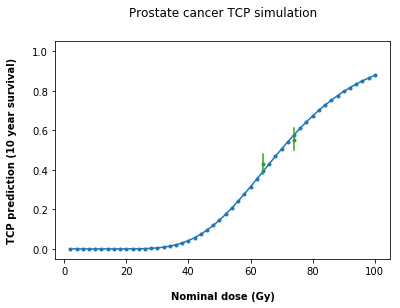

In [13]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('prost_10year-N0_determination.pkl') #prost_10year

## add some confidence intervals to the fit points
tcp_conf_intervals_1 = [0.38,0.48] # at 64Gy ## 95% CI from paper
tcp_conf_intervals_2 = [0.50,0.61] # at 74Gy

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3)


for i in [0,1]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')
plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)
plt.show()

In [14]:
## examine the data
plot_data['n0_use'] ## this is the N0 value which was determined from the above.

73.574156940716279

## Now simulate a single 'average' patient to determine parameter sensitivity
- No fitting required as N0 already determined.

In [15]:
prost_patient = model.completeTCPcalc(n=1,                  # number of patients in population to model
                      alphabeta_use=1.5,       # mean alpha/beta
                      alphabeta_sd_use=0,    # SD of alpha/beta (%)
                      d=2,                    # nominal dose (Gy/fraction)
                      d_shift=0,              # initial dose difference (%)
                      d_sd=0,                 # standard deviation of delivered dose (%)
                      d_trend=0,              # dose drift (%/day)
                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                      dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                      dose_input=[64,74],     # known doses corresponding to known TCPs to fit to
                      TCP_input=[0.43,0.55],
                      n0 = 74) # N0 as determnined through population fit

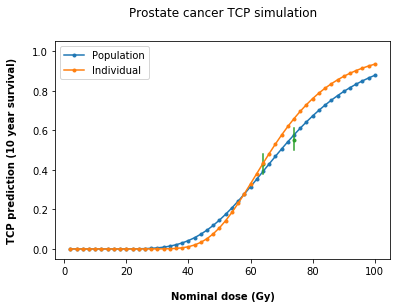

In [16]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('prost_10year-N0_determination.pkl') #prost_10year

## add some confidence intervals to the fit points
tcp_conf_intervals_1 = [0.38,0.48] # at 64Gy ## 95% CI from paper
tcp_conf_intervals_2 = [0.50,0.61] # at 74Gy

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3, label='Population')


for i in [0,1]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')

plt.plot(prost_patient['nom_doses'],prost_patient['TCP_pop'],marker='o',ms=3, label='Individual')

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)

plt.legend()
plt.show()


## if the 'average' N0 is used then TCP predicted is less well matched through the points.
## This is due to the lognormal alpha distribution...?
## continue to use as sensitivity unlikely to be affected by precise position of curve.

my_ab
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2}
{'my_n0': 74, 'my_ab': 1.53, 'my_d': 2}
my_d
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2}
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2.04}
my_n0
{'my_n0': 74, 'my_ab': 1.5, 'my_d': 2}
{'my_n0': 75.48, 'my_ab': 1.5, 'my_d': 2}
*New TCP Results*
{'my_n0': 65.389929395557516, 'my_ab': 67.140308692963231, 'my_d': 66.470716196986572}
Original TCP result
65.9368661888


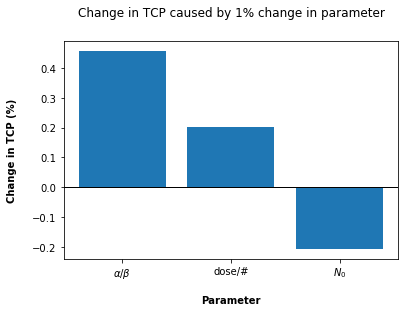

Sensitivity per % change in parameter
my_n0 -0.207371393612
my_ab 0.45628590411
my_d 0.20240953165


In [17]:
## now want to vary the parameters by a known amount (2%) to see the effect on the TCP at a specific dose (74Gy).
the_perc_dif = 2 # percentage variation to use
fact = 1+(the_perc_dif/100)
## more values will be completed for dose for the 'impact' section of the thesis.

## set the standard values which will be allowed to vary

## thse are the 3 main parameters which will affect a single patient. Others effect the fitting/populations
param_dict = {'my_ab':1.5,
              'my_d':2,
              'my_n0':74
              }

## loop the parameters to change them

all_params = sorted(param_dict) ## sort this for consistent use

results = {}

for param in all_params:
    
    param_dict_var = {k:v for (k,v) in param_dict.items()}
    param_dict_var[param] = param_dict[param]*fact ## increase one param by the factor
    
    print(param)
    print(param_dict)
    print(param_dict_var)


    prost_patient_dif = model.completeTCPcalc(n=1,  # number of patients in population to model
                          alphabeta_use=param_dict_var['my_ab'],       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=param_dict_var['my_d'],                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = param_dict_var['my_n0']) # N0 as determnined through population fit
    results[str(param)] = prost_patient_dif['TCP_cure_percent']

print('*New TCP Results*')
print(results) ## this is the TCP at 74Gy with the adjusted parameters

print('Original TCP result')
print(prost_patient['TCP_cure_percent'])

## now compare this TCP with the original
perc_dif = {}
for param in all_params:
    orig = prost_patient['TCP_cure_percent']
    new = results[param]
    the_dif = ((new/orig)-1)*100
    perc_dif[param] = the_dif/the_perc_dif ## devide by the percentage dif 
perc_dif

## quick plot
labels = [i for i in all_params]
formatted_labels = [r'$\alpha / \beta$', 'dose/#',r'$N_0$']
values = [perc_dif[i]/2 for i in all_params]
posns = [i for i in range(len(values))]
plt.bar(posns,values,tick_label=formatted_labels)
plt.axhline(0,color='black',lw=1,ls='-')
plt.ylabel('Change in TCP (%)')
plt.xlabel('Parameter')
plt.title('Change in TCP caused by 1% change in parameter')
#plt.savefig('prost_param_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()


print('Sensitivity per % change in parameter')
for i in perc_dif:
    print(i,perc_dif[i]/2)
## these are relatively low values due to shallow curve.

In [18]:
perc_dif

{'my_ab': 0.9125718082200196,
 'my_d': 0.4048190632995996,
 'my_n0': -0.41474278722404279}

## H&N
- Get data for this and run in same way as above to get sensitivities.
- could put all data on same plot to indicate difference, depends how marked the differences are.

- Data from
    - Nutting CM, Morden JP, Harrington KJ, Urbano TG, Bhide SA, Clark C, et al. Parotid-sparing intensity modulated versus conventional radiotherapy in head and neck cancer (PARSPORT): A phase 3 multicentre randomised controlled trial. Lancet Oncol. 2011;12(2):127–36. 
    
- Dose to PTV = 65Gy (median)
- TCP = {66% survival at 2 years} 79% [63-89 CI] from above paper (2 year locoregional progression-free survival survival average from IMRT (78% [62-87=95% CI]) and Converntional (80% [65-90 = 95%CI]) (no sig dif between IMRT and conf). conventional radiotherapy 80% (95% CI 65 to 90) and for IMRT 78% (62 to 87)
- ***TCP used = 2 year overall survival = 66%. Based on 38 total deaths of 47x7=94 patients.
- a/b = 10 [numerous papers etc...]
- a/b SD - same as for prostate = 50% as this was a good fit to the model, so reasonable assumption
- d = 65/30 Gy/# = 2.167Gy/#
- d_interest = 65Gy

In [12]:
## example TCP modelling - H&N 5 year survival

do_modelling = True

for i in range(5):
    if do_modelling == True: ## do not need to do this if can just load previous results.

        hn_5year = model.completeTCPcalc(n=1,                  # number of patients in population to model
                              alphabeta_use=10,       # mean alpha/beta
                              alphabeta_sd_use=0,    # SD of alpha/beta (%)
                              d=65/30,                    # nominal dose (Gy/fraction)
                              d_shift=0,              # initial dose difference (%)
                              d_sd=0,                 # standard deviation of delivered dose (%)
                              d_trend=0,              # dose drift (%/day)
                              max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                              dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                              dose_input=[65],     # known doses corresponding to known TCPs to fit to
                              TCP_input=[0.66],) # known TCPs corresponding to doses to fit to.
    #print(hn_5year['n0_use'])
    
## fitting didnt work well here. Very inconsistent... repeat multiple times and average

N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed
N0 not provided - will calculate N0
Fitting N0 value
Fitting N0: Stage 5 of 5N0 fit: 3073818.54262

Fitting Completed


In [20]:
all_n0 = [2162.57839909,26848.8740655,821.302040827,12425.0540082,9564.69489905]
all_n0_1 = [484.480495083,378.041498923,177.868736443,5435.23209056,9527.98421258]
print(np.mean(all_n0))
print(np.mean(all_n0_1))
## mean N0 ~ 10000 - use this value or slightly higher gives a better fit.

10364.5006825
3200.72140672


In [21]:
## save the above results:
#save_pkl(hn_5year1,'hn_5year1-N0_determination.pkl')

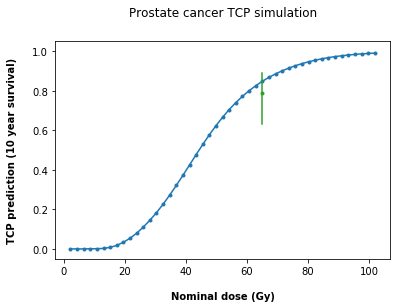

In [22]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('hn_5year-N0_determination.pkl') #prost_10year

## add some confidence intervals to the fit points
tcp_conf_intervals_1 = [0.63,0.89] # at 65Gy ## 95% CI from paper

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3)


for i in [0]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')
plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)
plt.show()

In [23]:
## examine the data
plot_data['n0_use'] ## this is the N0 value which was determined from the above.

9527.9842125756841

In [13]:
hn_patient = model.completeTCPcalc(n=1,                  # number of patients in population to model
                      alphabeta_use=10,       # mean alpha/beta
                      alphabeta_sd_use=0,    # SD of alpha/beta (%)
                      d=65/30,                    # nominal dose (Gy/fraction)
                      d_shift=0,              # initial dose difference (%)
                      d_sd=0,                 # standard deviation of delivered dose (%)
                      d_trend=0,              # dose drift (%/day)
                      max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                      dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                      dose_input=[65],     # known doses corresponding to known TCPs to fit to
                      TCP_input=[0.79],
                      n0 = 1500000) # N0 as determnined through population fit

## large value of N0 used (manually determined to make sure it is appropriate.) - steep gradient required

NameError: name 'tcp_conf_intervals_1' is not defined

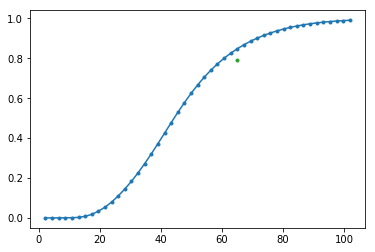

In [14]:
## select the data to plot for ease - load from saved file
plot_data = load_pkl('hn_5year-N0_determination.pkl') #prost_10year

plt.plot(plot_data['nom_doses'],plot_data['TCP_pop'],marker='o',ms=3, label='Population')


for i in [0]:
    plt.plot(plot_data['dose_input'][i],plot_data['TCP_input'][i],'o',ms=3,c='C2')
    if i == 0:
        tcp = tcp_conf_intervals_1
    if i == 1:
        tcp = tcp_conf_intervals_2
    plt.plot([plot_data['dose_input'][i]]*2,tcp,c='C2')

plt.plot(hn_patient['nom_doses'],hn_patient['TCP_pop'],marker='o',ms=3, label='Individual')

plt.xlabel('Nominal dose (Gy)')
plt.ylabel('TCP prediction (10 year survival)')
plt.title('Prostate cancer TCP simulation')

plt.ylim(-0.05,1.05)

plt.legend()
plt.show()

## N0 was set manually for hte individual 'average' pateint
## individual curve is much steeper

In [15]:
## now want to vary the parameters by a known amount (2%) to see the effect on the TCP at a specific dose (74Gy).
the_perc_dif = 2 # percentage variation to use
fact = 1+(the_perc_dif/100)
## more values will be completed for dose for the 'impact' section of the thesis.

## set the standard values which will be allowed to vary

## thse are the 3 main parameters which will affect a single patient. Others effect the fitting/populations
param_dict = {'my_ab':10,
              'my_d':65/30,
              'my_n0':1500000
              }

## loop the parameters to change them

all_params = sorted(param_dict) ## sort this for consistent use

results = {}

for param in all_params:
    
    param_dict_var = {k:v for (k,v) in param_dict.items()}
    param_dict_var[param] = param_dict[param]*fact ## increase one param by the factor
    
    print(param)
    print(param_dict)
    print(param_dict_var)


    hn_patient_dif = model.completeTCPcalc(n=1,  # number of patients in population to model
                          alphabeta_use=param_dict_var['my_ab'],       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=param_dict_var['my_d'],                    # nominal dose (Gy/fraction)
                          d_shift=param_dict_var,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = param_dict_var['my_n0']) # N0 as determnined through population fit
    results[str(param)] = hn_patient_dif['TCP_cure_percent']

print('*New TCP Results*')
print(results) ## this is the TCP at 74Gy with the adjusted parameters

print('Original TCP result')
print(hn_patient['TCP_cure_percent'])

## now compare this TCP with the original
perc_dif = {}
for param in all_params:
    orig = hn_patient['TCP_cure_percent']
    new = results[param]
    the_dif = ((new/orig)-1)*100
    perc_dif[param] = the_dif/the_perc_dif ## devide by the percentage dif 
perc_dif

## quick plot
labels = [i for i in all_params]
formatted_labels = [r'$\alpha / \beta$', 'dose/#',r'$N_0$']
values = [perc_dif[i]/2 for i in all_params]
posns = [i for i in range(len(values))]
plt.bar(posns,values,tick_label=formatted_labels)
plt.axhline(0,color='black',lw=1,ls='-')
plt.ylabel('Change in TCP (%)')
plt.xlabel('Parameter')
plt.title('Change in TCP caused by 1% change in parameter')
#plt.savefig('hn_param_sensitivity.png',dpi=300,bbox_inches='tight')
plt.show()


print('Sensitivity per % change in parameter')
for i in perc_dif:
    print(i,perc_dif[i]/2)
## these are relatively low values due to shallow curve.

my_ab
{'my_d': 2.1666666666666665, 'my_ab': 10, 'my_n0': 1500000}
{'my_d': 2.1666666666666665, 'my_ab': 10.2, 'my_n0': 1500000}


TypeError: unsupported operand type(s) for *: 'float' and 'dict'

In [18]:

## do manually...as its easier to keep track.
print('------H&N------')
print('TCP for dose dif of 0 and +1%')
dose_dif = [0,1]

for the_fact in dose_dif:

    hn_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=10,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=65/30,                    # nominal dose (Gy/fraction)
                          d_shift=the_fact,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 3000000) # N0 as determnined through population fit
    print(the_fact,hn_patient1['TCP_cure_percent'])

print('')
print('TCP for ab dif of 0 and +1%')
ab_fact = [1,1.01]

for the_fact in ab_fact:

    hn_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=10*the_fact,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=65/30,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 3000000) # N0 as determnined through population fit
    print(the_fact,hn_patient1['TCP_cure_percent'])
    
print('')
print('TCP for N0 dif of 0 and +1%')
n0_fact = [1,1.01]

for the_fact in n0_fact:

    hn_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=10,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=65/30,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=65,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 3000000*the_fact) # N0 as determnined through population fit
    print(the_fact,hn_patient1['TCP_cure_percent'])

------H&N------
TCP for dose dif of 0 and +1%
0 66.6618917755
1 71.4266289801

TCP for ab dif of 0 and +1%
1 66.6618917755
1.01 70.0402609232

TCP for N0 dif of 0 and +1%
1 66.6618917755
1.01 66.3921007374


In [17]:

## do manually...as its easier to keep track.
print('------Prostate------')
print('TCP for dose dif of 0 and +1%')
dose_dif = [0,1]

prost_perc_difs = {}

for the_fact in dose_dif:

    prost_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=1.5,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=the_fact,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 74) # N0 as determnined through population fit
    print(the_fact,prost_patient1['TCP_cure_percent'])

print('')
print('TCP for ab dif of 0 and +1%')
ab_fact = [1,1.01]

for the_fact in ab_fact:

    prost_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=1.5*the_fact,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 74) # N0 as determnined through population fit
    print(the_fact,prost_patient1['TCP_cure_percent'])
    
print('')
print('TCP for N0 dif of 0 and +1%')
n0_fact = [1,1.01]

for the_fact in n0_fact:

    prost_patient1 = model.completeTCPcalc(n=1,                  # number of patients in population to model
                          alphabeta_use=1.5,       # mean alpha/beta
                          alphabeta_sd_use=0,    # SD of alpha/beta (%)
                          d=2,                    # nominal dose (Gy/fraction)
                          d_shift=0,              # initial dose difference (%)
                          d_sd=0,                 # standard deviation of delivered dose (%)
                          d_trend=0,              # dose drift (%/day)
                          max_d=100,              # maximum dose for which TCP is calcualted (Gy)
                          dose_of_interest=74,    # results of TCP at this dose are returned seperately for simpler analysis.
                          n0 = 74*the_fact) # N0 as determnined through population fit
    print(the_fact,prost_patient1['TCP_cure_percent'])
    


------Prostate------
TCP for dose dif of 0 and +1%
0 65.9368661888
1 68.1266937948

TCP for ab dif of 0 and +1%
1 65.9368661888
1.01 66.5425457205

TCP for N0 dif of 0 and +1%
1 65.9368661888
1.01 65.6628283327


Calculated TCP values. Need to convert to sensitivities

### ------H&N------
TCP for dose dif of 0 and +1%
0 81.6467340287
1 84.514276297

TCP for ab dif of 0 and +1%
1 81.6467340287
1.01 83.6900596984

TCP for N0 dif of 0 and +1%
1 81.6467340287
1.01 81.4813480113

### ----------- H&N2 --------

------H&N------
TCP for dose dif of 0 and +1%
0 66.6618917755
1 71.4266289801

TCP for ab dif of 0 and +1%
1 66.6618917755
1.01 70.0402609232

TCP for N0 dif of 0 and +1%
1 66.6618917755
1.01 66.3921007374


### ------Prostate------
TCP for dose dif of 0 and +1%
0 65.9368661888
1 68.1266937948

TCP for ab dif of 0 and +1%
1 65.9368661888
1.01 66.5425457205

TCP for N0 dif of 0 and +1%
1 65.9368661888
1.01 65.6628283327

Summary:
Dose sensitivity
HN:((71.4266289801/66.6618917755)-1)*100
Prostate((68.1266937948/65.9368661888)-1)*100

A:B sensitivity
HN:((70.0402609232/66.6618917755)-1)*100
Prostate((66.5425457205/65.9368661888)-1)*100

N0 sensitivity
HN:((66.3921007374/66.6618917755)-1)*100
Prostate((65.6628283327/65.9368661888)-1)*100

In [19]:
## the above in code so can use and plot etc.

sensitivity = {'dose':{
'hn':((71.4266289801/66.6618917755)-1)*100,
'prostate':((68.1266937948/65.9368661888)-1)*100},

'ab':{
'hn':((70.0402609232/66.6618917755)-1)*100,
'prostate':((66.5425457205/65.9368661888)-1)*100},

'n0':{
'hn':((66.3921007374/66.6618917755)-1)*100,
'prostate':((65.6628283327/65.9368661888)-1)*100}
    }

sensitivity

{'ab': {'hn': 5.06791670281046, 'prostate': 0.9185749440468349},
 'dose': {'hn': 7.147617743352397, 'prostate': 3.321097486995783},
 'n0': {'hn': -0.4047155442401529, 'prostate': -0.41560643072622305}}

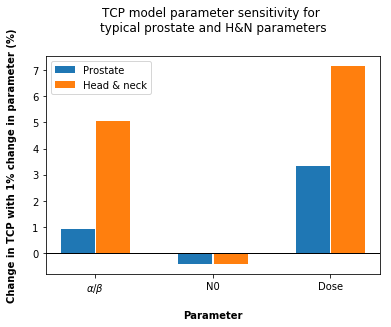

[0.9185749440468349, -0.41560643072622305, 3.321097486995783]
[5.06791670281046, -0.4047155442401529, 7.147617743352397]
['$\\alpha / \\beta$', 'N0', 'Dose']


In [22]:
## plot each set of data:

labels = {'ab':r'$\alpha / \beta$',
         'dose': 'Dose',
         'n0':'N0'}

my_param = []
hn = []
prostate = []
use_labels = []
for i in sensitivity:
    my_param.append(i)
    hn.append(sensitivity[i]['hn'])
    prostate.append(sensitivity[i]['prostate'])
    use_labels.append(labels[i])

offset = 0.15
#plt.bar(posns,values,tick_label=formatted_labels)

width = 0.29
hn_posn = [i+offset for i in range(3)]
prost_posn = [i-offset for i in range(3)]

plt.bar(prost_posn,prostate,tick_label=use_labels,color='C0',width=width,label='Prostate')
plt.bar(hn_posn,hn,tick_label=use_labels,color='C1',width=width,label='Head & neck')
plt.xticks(range(3),use_labels)
plt.axhline(0,color='black',lw=1)

plt.ylabel('Change in TCP with 1% change in parameter (%)')
plt.xlabel('Parameter')
plt.title('TCP model parameter sensitivity for \ntypical prostate and H&N parameters')

#plt.ylim(-1,4)
plt.legend()

#plt.savefig('param_sensitivity-prost_hn2.png',dpi=300,bbox_inches='tight')

plt.show()


print(prostate)
print(hn)
print(use_labels)

# NTCP Characterisation

Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***
Calculating Individual Patient NTCP curves
*** NTCP Simulation Completed ***


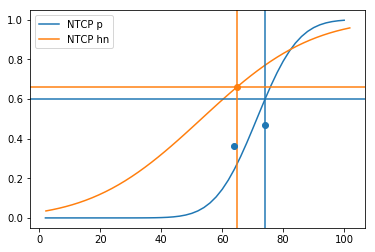

p TCP: 0.597382175553
hn TCP: 0.661886810255


In [5]:
## Example dose calculation.
## The values of V were determined by optimising the curve fit based on the supplied dose/NTPC values.

## this TCP part is only used to get a list of fraction doses and nominal doses
## this is easiest as the dose variaiotn is builtin.
TCP_results_p = model.completeTCPcalc(n=1,
                                      alphabeta_use=1.5,
                                      alphabeta_sd_use=0,
                                      d=2,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=74,
                                      n0 = 74) ##*********

TCP_results_hn = model.completeTCPcalc(n=1,
                                      alphabeta_use=10,
                                      alphabeta_sd_use=0,
                                      d=65/30,
                                      d_shift=0, # no shift as start each treatment as if perfect
                                      d_sd=0,
                                      d_trend=0, # vary the trend value
                                      max_d=100,
                                      dose_of_interest=65,
                                      n0 = 3000000) ##*********

frac_doses_p = TCP_results_p['doses']
nom_doses_p = TCP_results_p['nom_doses']
frac_doses_hn = TCP_results_hn['doses']
nom_doses_hn = TCP_results_hn['nom_doses'] 

## v is manually determined based ont he TCP/dose points

NTCP_results_p = model.complete_NTCP_calc(d_data=[64,74],
                                       ntcp_data=[0.36,0.47],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_p,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(68.5,0),
                                                    'v': (0.73,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.15,0),
                                                    'n':(0.13,0)}, #(1,0)
                                       fit_vals=False)

NTCP_results_hn = model.complete_NTCP_calc(d_data=[65],
                                       ntcp_data=[0.66],
                                       irrad_perc = 100, ## scaling factor?
                                       frac_doses=frac_doses_hn,
                                       max_dose=100,
                                       ntcp_params={'td50_1':(31.4,0),
                                                    'v': (0.59,0),#(0.08,10), ##v=1 for parotid (low for rrectum?)
                                                    'm':(0.53,0),
                                                    'n':(1,0)}, #(1,0)
                                       fit_vals=False)

plt.plot(nom_doses_p,NTCP_results_p['patient_ntcps'][0],label='NTCP p')
plt.plot(nom_doses_hn,NTCP_results_hn['patient_ntcps'][0],label='NTCP hn')
## show dose of interest point
plt.axvline(74,c=color_p)
plt.axhline(NTCP_results_p['patient_ntcps'][0][36],c=color_p)
plt.axvline(65,c=color_hn)
plt.axhline(NTCP_results_hn['patient_ntcps'][0][29],c=color_hn)

## show dose points
plt.plot(NTCP_results_p['d_data'],NTCP_results_p['ntcp_data'],'o',c=color_p)
plt.plot(NTCP_results_hn['d_data'],NTCP_results_hn['ntcp_data'],'o',c=color_hn)

plt.legend()
plt.show()

## get TCP at doses of interest.

print('p TCP:',NTCP_results_p['patient_ntcps'][0][36])
print('hn TCP:',NTCP_results_hn['patient_ntcps'][0][29])